In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import itertools
from attrbench import datasets, attribution, models
from os import path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from attrbench.evaluation.impact_score import impact_score

In [11]:
device = "cpu"
dataset_name = "CIFAR10"
model_name = "resnet18"
download_dataset = False
batch_size = 16
n_batches = 16
n_subsets = 100
mask_range = range(1, 500, 50)
tau = 0.5
data_root = "../data"
normalize_attrs = True
aggregation_fn = "avg"

In [12]:
dataset = datasets.Cifar(batch_size=batch_size, data_location=path.join(data_root, dataset_name))
model = models.Resnet(version=model_name, params_loc=path.join(data_root, f"models/{dataset_name}/{model_name}.pt"),
                      output_logits=True, num_classes=10)
model.to(device)
model.eval()
pass  # Prevents output from model.eval()

In [14]:
kwargs = {
    "normalize": normalize_attrs,
    "aggregation_fn": aggregation_fn
}

attribution_methods = {
    "GuidedGradCAM": attribution.GuidedGradCAM(model, model.get_last_conv_layer(), **kwargs),
    "Gradient": attribution.Gradient(model, **kwargs),
    "InputXGradient": attribution.InputXGradient(model, **kwargs),
    "IntegratedGradients": attribution.IntegratedGradients(model, **kwargs),
    "GuidedBackprop": attribution.GuidedBackprop(model, **kwargs),
    "Deconvolution": attribution.Deconvolution(model, **kwargs),
    "Random": attribution.Random(**kwargs)
}

In [15]:
i_score, i_strict_score = impact_score(itertools.islice(dataset.get_dataloader(train=False), n_batches), model, list(mask_range), methods=attribution_methods, mask_value=dataset.mask_value, tau=tau, device=device)

/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.7/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


In [7]:
i_score_df = pd.DataFrame.from_dict(i_score).stack().reset_index()
i_score_df.columns = ["n", "method", "score"]
i_score_df["n"] = np.array(mask_range)[i_score_df["n"]]
i_score_df

,n,method,score
0,1,GuidedGradCAM,0.023438
1,1,Gradient,0.027344
2,1,InputXGradient,0.023438
3,1,IntegratedGradients,0.019531
4,1,GuidedBackprop,0.039062
...,...,...,...
65,451,InputXGradient,0.691406
66,451,IntegratedGradients,0.687500
67,451,GuidedBackprop,0.804688
68,451,Deconvolution,0.898438


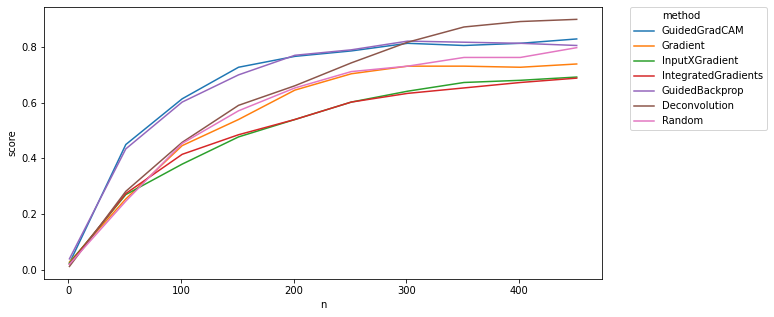

In [8]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="n", y="score", hue="method", data=i_score_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [9]:
i_strict_score_df = pd.DataFrame.from_dict(i_strict_score).stack().reset_index()
i_strict_score_df.columns = ["n", "method", "score"]
i_strict_score_df["n"] = np.array(mask_range)[i_strict_score_df["n"]]
i_strict_score_df

,n,method,score
0,1,GuidedGradCAM,0.023438
1,1,Gradient,0.027344
2,1,InputXGradient,0.023438
3,1,IntegratedGradients,0.019531
4,1,GuidedBackprop,0.039062
...,...,...,...
65,451,InputXGradient,0.671875
66,451,IntegratedGradients,0.667969
67,451,GuidedBackprop,0.769531
68,451,Deconvolution,0.808594


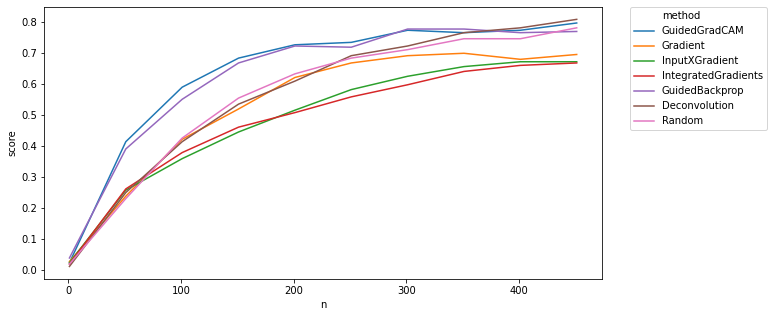

In [10]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="n", y="score", hue="method", data=i_strict_score_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)